In [1]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
import matplotlib.pyplot as plt

# from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix


In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
parent_path = '/content/drive/MyDrive/Colab Notebooks/ml-buisness/lection3_materials/'

Mounted at /content/drive


# load data

In [4]:
# load data
data = pd.read_csv(parent_path + 'train_case2.csv', sep=';')
train = data.drop(columns='cardio').copy()
y_true = data['cardio']
data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


# common correctors

In [5]:
class Quantile_corrector(BaseEstimator, TransformerMixin):
  def __init__(self, field, lower=0.05, upper=0.95, method=np.median, calc_avg_on='fit'):
    self.lower = lower if 0 < lower < upper else 0
    self.upper = upper if lower < upper else 1
    self.field = field
    self.lower_quantile = None
    self.upper_quantile = None
    self.method = method
    self.avg = None
    self.calc_avg_on = calc_avg_on

  def fit(self, X, y=None):
    self.lower_quantile = X[self.field].quantile(self.lower)
    self.upper_quantile = X[self.field].quantile(self.upper)
    self.avg = self.method(X[self.field])
    return self
  
  def transform(self, X):
    X = X.copy()
    feat = X[self.field].copy()
    out_lower = feat < self.lower_quantile
    out_upper = feat > self.upper_quantile
    feat[out_lower | out_upper] = self.avg if self.calc_avg_on == 'fit' else self.method(feat)

    X[self.field] = feat
    corrected = out_lower | out_upper
    X[f'{self.field}_corrected'] = 0
    X.loc[corrected, f'{self.field}_corrected'] = 1
    return X

# EDA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Пропусков нет, это хорошо. 

In [7]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Features description
1. Age | Objective Feature | age | int (days)
2. Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |
3. Height | Objective Feature | height | int (cm) |
4. Weight | Objective Feature | weight | float (kg) |
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol |
    1: normal, 
    2: above normal, 
    3: well above normal |
8. Glucose | Examination Feature | gluc |
    1: normal, 
    2: above normal,
    3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Отчетливо видны выбросы в `height`,  `weight`, `ap_hi`, `ap_lo`

### target

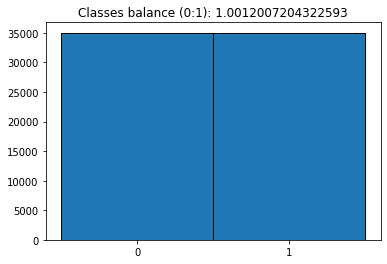

In [8]:
# распределение классов
target = 'cardio'

clases_count = data[target].value_counts()
disbalance = clases_count[0] / clases_count[1]

plt.hist(data[target], bins=2, edgecolor='black')
plt.title(f'Classes balance (0:1): {disbalance}')
plt.xticks([0.25, 0.75], labels=clases_count.index)
plt.show()

Дисбаланс классов незначительный

### age

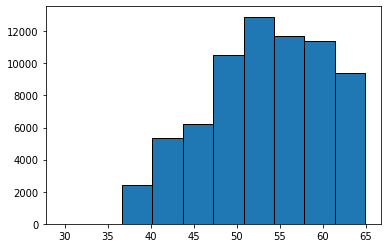

In [9]:
plt.hist(data['age'] / 365.25, edgecolor='black')
plt.show()

Выбросов и неадекватных значений по графику не видно

### gender

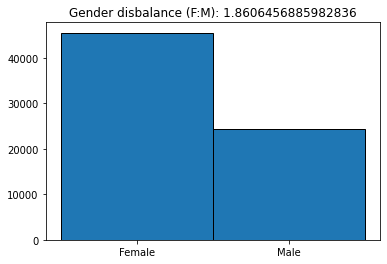

In [10]:
cls_count = data['gender'].value_counts()
disbal = cls_count[1] / cls_count[2]
plt.hist(data['gender'], bins=2, edgecolor='black')
plt.title(f'Gender disbalance (F:M): {disbal}')
plt.xticks([1.25, 1.75], labels=['Female', 'Male'])
plt.show()

Женщин в выборке почти в 2 раза больше, чем мужчин

### height

Самый низкорослый человек в мире имел рост ~67см, соотв. все, что ниже этого значения абсолютно точно - некорректно. Попробуем ограничить выборку по квантилям.

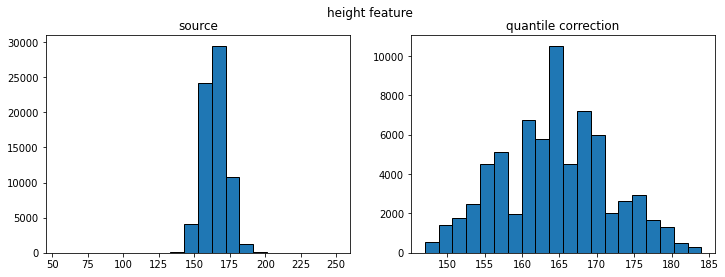

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('height feature')
ax[0].set_title('source')
ax[0].hist(data['height'], edgecolor='black', bins=20)
ax[1].set_title('quantile correction')
qc = Quantile_corrector('height', lower=0.01, upper=0.99, method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['height'], edgecolor='black', bins=20)
plt.show()

### weight

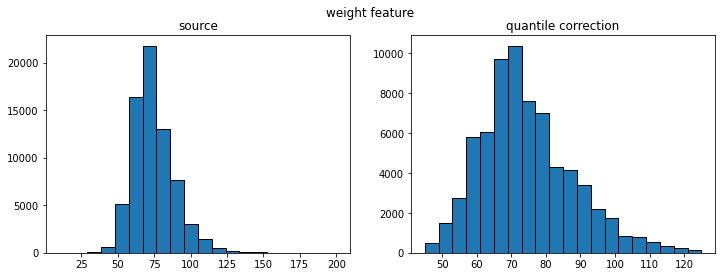

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('weight feature')
ax[0].set_title('source')
ax[0].hist(data['weight'], edgecolor='black', bins=20)
ax[1].set_title('quantile correction')
qc = Quantile_corrector('weight', lower=0.005, upper=0.995, method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['weight'], edgecolor='black', bins=20)
plt.show()

Распределение веса, в целом, выглядит вполне возможным, но есть небольшое кол-во экстремально малых значений, которые выглядят неправдоподобно.
При этом высокие значения вполне реальны и могут быть обоснованны в контексте задачи

### ap_hi

Давление не может быть открицательным. Норма систолического давления лежит в диапазоне от 90 до 120. 

Снижение давления на 20% (и более) от обычного значения это уже гипотензия и требует неотложной медицинской помощи. В абсолютных цифрах это значение ~70, его и примем за минимально допустимое.

Систоличесское давление 250 это совсем уже гипертонический криз, поэтому примем это значение за максимально допустимое.

In [13]:
data[data['ap_hi'] < 0].size

91

In [14]:
data[data['ap_hi'] < 70].head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
567,815,21281,1,168,78.0,14,90,2,1,0,0,1,1
927,1294,21867,2,175,70.0,14,90,3,1,0,0,1,1
979,1360,18225,1,172,65.0,11,80,1,3,0,0,1,0


In [15]:
data[data['ap_hi'] > 250].head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1876,2654,15116,1,160,60.0,902,60,1,1,0,0,1,0
2014,2845,22712,2,167,59.0,906,0,1,1,0,0,1,0
4817,6822,14425,1,168,63.0,909,60,2,1,0,0,1,0


In [16]:
class Correct_ap_hi(BaseEstimator, TransformerMixin):
  def __init__(self, method=np.median, calc_avg_on='fit'):
    self.avg = None
    self.method = method
    self.calc_avg_on = calc_avg_on

  def fit(self, X, y=None):
    self.avg = self.method(X['ap_hi'])
    return self
  
  def transform(self, X):
    # select column
    feat = X['ap_hi'].copy()
    # switch sign for negative values
    out_neg = feat < 0
    feat[out_neg] = -feat[out_neg]
    # correct extremely low values
    out_lower = feat < 70
    feat[out_lower] = feat[out_lower] * 10
    # correct extremely high values
    out_upper = feat > 250
    feat[out_upper] = (feat[out_upper] / 10 ** np.round(np.log10(feat[out_upper]) - 2)).astype(np.int64)
    # correct secondary outliers
    out_secondary = (feat < 70) | (feat > 250)
    # feat[out_secondary] = int(feat.mean())
    feat[out_secondary] = int(self.avg if self.calc_avg_on == 'fit' else self.method(feat[~out_secondary]))

    X = X.copy()
    X['ap_hi'] = feat
    corrected = out_neg | out_lower | out_upper | out_secondary
    X['ap_hi_corrected'] = 0
    X.loc[corrected == True, 'ap_hi_corrected'] = 1
    return X

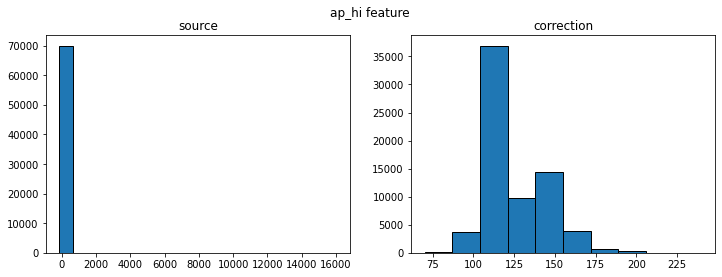

In [17]:
# ap_hi
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('ap_hi feature')
ax[0].set_title('source')
ax[0].hist(data['ap_hi'], edgecolor='black', bins=20)
ax[1].set_title('correction')
qc = Correct_ap_hi(method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['ap_hi'], edgecolor='black')
plt.show()

### ap_lo

Давление не может быть открицательным. Норма диастолического давления лежит в диапазоне от 60 до 80. 

Как базовое решение, исправим пропуски мат.ожиданием/медианой.

In [18]:
data[data['ap_lo'] < 0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,85816,22571,1,167,74.0,15,-70,1,1,0,0,1,1


In [19]:
data.loc[(data['ap_lo'] >= 0) & (data['ap_lo'] < 48), 'ap_lo'].size

77

In [20]:
data.loc[data['ap_lo'] > 160, 'ap_lo'].size

966

In [21]:
class Correct_ap_lo(BaseEstimator, TransformerMixin):
  def __init__(self, method=np.median, calc_avg_on='fit'):
    self.avg = None
    self.method = method
    self.calc_avg_on = calc_avg_on

  def fit(self, X, y=None):
    self.avg = self.method(X['ap_lo'])
    return self
  
  def transform(self, X):
    # select column
    feat = X['ap_lo'].copy()
    # switch sign for negative values
    out_neg = feat < 0
    feat[out_neg] = -feat[out_neg]
    # correct extremely low values with meanc
    out_lower_baseline = (feat >= 0) & (feat <= 48)
    # correct extremely high values with meanc
    out_upper_baseline = feat > 160
    feat[out_lower_baseline | out_upper_baseline] = int(self.avg if self.calc_avg_on == 'fit' else feat[~out_lower_baseline & ~out_upper_baseline].median())

    X = X.copy()
    X['ap_lo'] = feat
    corrected = out_lower_baseline | out_upper_baseline
    X['ap_lo_corrected'] = 0
    X.loc[corrected,  'ap_lo_corrected'] = 1
    return X

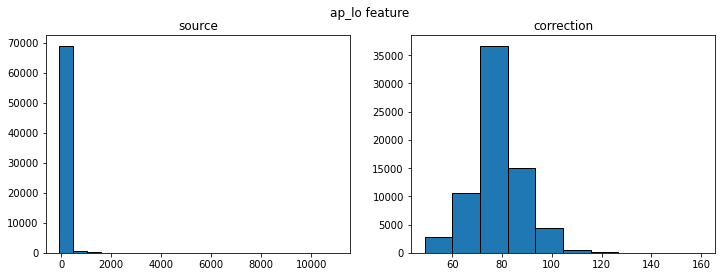

In [22]:
# ap_lo
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('ap_lo feature')
ax[0].set_title('source')
ax[0].hist(data['ap_lo'], edgecolor='black', bins=20)
ax[1].set_title('correction')
qc = Correct_ap_lo(method=np.median, calc_avg_on='fit')
qc.fit(data)
ax[1].hist(qc.transform(data)['ap_lo'], edgecolor='black')
plt.show()

# Featuring

In [23]:
class Featuring(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    X = X.copy()
    # classic BMI
    X['BMI'] = X['weight'] / (X['height'] / 100) ** 2
    # new BMI (by Nick Trefethen)
    X['new_BMI'] = 1.3 * X['weight'] / (X['height'] / 100) ** 2.5
    
    return X

In [24]:
class DropColumns(BaseEstimator, TransformerMixin):
  def __init__(self, **kwargs):
    self.drop = kwargs.get('drop', [])
    self.leave = kwargs.get('leave', [])

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.leave:
      return X[self.leave]
    elif self.drop:
      return X.drop(columns=self.drop)
    else:
      return X

In [25]:
class DataScaler(BaseEstimator, TransformerMixin):
  def __init__(self, scaler, columns=[], keep=[]):
    self.scaler = scaler
    self.cols = columns
    self.keep = keep
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    df = X.copy()
    if self.keep:
      columns = [col for col in df.columns if col not in self.keep]
    elif not self.cols:
      columns = df.columns
    self.scaler.fit(df[columns])
    df[columns] = self.scaler.transform(df[columns])
    return df

# Data preparing pipelines

In [26]:
prepare = Pipeline([('height_correction', Quantile_corrector('height', lower=0.01, upper=0.99)),
                    ('weight_correction', Quantile_corrector('weight', lower=0.0025, upper=1)),
                    ('ap_hi correction', Correct_ap_hi(method=np.median, calc_avg_on='fit')),
                    ('ap_lo correction', Correct_ap_lo(method=np.median, calc_avg_on='fit')),
                    ('featuring', Featuring()),
                    ('drop', DropColumns(drop=['id'])),
                    ])

In [27]:
lin_prepare = Pipeline([('preprocessing', prepare),
                        ('scale', DataScaler(StandardScaler(), )),
                        ])

# modeling

In [28]:
def fit_models(X, y, preparator, ModelClass, model_params, folds=5, average_method=np.mean, random_state=None):
  """ 
  preparator - data preparing pipeline
  ModelClass - estimator class
  model_params - estimator init parameters
  average_method - func to calc avg.metrics. Return metrics for each split if None
  """
  model_params.pop('random_state', None)
  rng = np.random.default_rng(random_state)
  # prepare 
  # model = ModelClass(**model_params, random_state=rng.integers(1000))
  model = ModelClass(**model_params)
  kf = KFold(n_splits=folds, shuffle=True, random_state=rng.integers(1000))

  # prepare data
  preparator.fit(X, y_true)
  X_whole = preparator.transform(train)
  y_whole = y_true.copy()
  # get scores
  scores = cross_validate(model, X_whole, y_whole,
                          scoring=['precision', 'recall', 'f1', 'roc_auc'],     # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                          cv=kf, n_jobs=-1)
  return average_method(pd.DataFrame(scores))

In [30]:
folds = 3
model_random_state = 23
split_random_state = 223

metrics = []
metrics_cols = ['model', 'fit_time', 'score_time', 'precision', 'recall', 'f1', 'roc_auc']

# LogReg
logreg_params = {'class_weight': 'balanced',
                 'n_jobs': -1,
                 'random_state': model_random_state
                 }
scores = fit_models(train, y_true, lin_prepare, LogisticRegression, logreg_params, folds=folds, random_state=split_random_state)
metrics.append(['LogReg', *scores.values])

# SGD
sgd_params = {'class_weight': 'balanced',
              'max_iter': 200,
             #  'loss': 'modified_huber',
              'loss': 'log',
              'n_jobs': -1,
              'random_state': model_random_state
              }
scores = fit_models(train, y_true, lin_prepare, SGDClassifier, sgd_params, folds=folds, random_state=split_random_state)
metrics.append(['SGD', *scores.values])

# catboost
categories = ['gender', 'smoke', 'alco', 'active', 'height_corrected', 'weight_corrected', 'ap_hi_corrected', 'ap_lo_corrected']
catbst_params = {'allow_writing_files': False,
                 'cat_features': categories,
                 'random_state': model_random_state
                 }
scores = fit_models(train, y_true, prepare, CatBoostClassifier, catbst_params, folds=folds, random_state=split_random_state)
metrics.append(['CatBoost', *scores.values])

# random forest
rf_params = {'class_weight': 'balanced',
             'n_jobs': -1,
             'max_depth': 5,
             'random_state': model_random_state
             }
scores = fit_models(train, y_true, prepare, RandomForestClassifier, rf_params, folds=folds, random_state=split_random_state)
metrics.append(['RandomForest', *scores.values])

# xgboost
xgb_params = {'random_state': model_random_state}
scores = fit_models(train, y_true, prepare, XGBClassifier, xgb_params, folds=folds, random_state=split_random_state)
metrics.append(['XGBoost', *scores.values])


# LGB
lgb_params = {'n_jobs': -1,
              'random_state': model_random_state,
              }

scores = fit_models(train, y_true, prepare, LGBMClassifier, lgb_params, folds=folds, random_state=split_random_state)
metrics.append(['LGBM', *scores.values])

# KNN
knn_params = {'n_neighbors': 5,
              'n_jobs': -1,
             }
scores = fit_models(train, y_true, lin_prepare, KNeighborsClassifier, knn_params, folds=folds, random_state=split_random_state)
metrics.append(['KNN', *scores.values])

# final results
metrics = pd.DataFrame(metrics, columns=metrics_cols)
metrics

,model,fit_time,score_time,precision,recall,f1,roc_auc
0,LogReg,0.377096,0.057592,0.755926,0.675019,0.713180,0.792265
1,SGD,0.375938,0.059398,0.758359,0.653318,0.701907,0.784836
2,CatBoost,28.506759,0.374310,0.754785,0.696643,0.724548,0.801761
3,RandomForest,3.046978,0.591066,0.766331,0.661948,0.710322,0.795483
4,XGBoost,4.435652,0.247036,0.755161,0.696432,0.724607,0.802630
5,LGBM,0.989264,0.446165,0.757177,0.698078,0.726426,0.802643
6,KNN,0.028801,88.682964,0.699561,0.685801,0.692613,0.744442


В принципе, метрики отличаются не сильно (кроме kNN). Скорее всего, при более тщательной предобработке данных, feature-engineering'е и настройке гиперпараметров, различия усилятся, и тогда можно будет более обоснованно подойти к выбору модели.

В контексте имеющегося решения (при данных пайплайнах, гиперпараметрах, etc.), оптимальным выбором мне кажется LGBM или XGBoost. Но если критично важна скорость обучения/предсказания, то однозначно LogReg.

__5.__ Какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов?

Для задачи бинарной классификации метрики рассчитываются следующим образом:

$precision = \frac{TP}{TP + FP}$

$recall = \frac{TP}{TP + FN}$

$TPR = \frac{TP}{TP + FN}$

$FPR = \frac{FP}{FP + TN}$

Рассмотрим confusion matrix

$\matrix{
  TP & FP \\
  FN & TN \\
}$

Можно заметить, что $recall$, $TPR$ и $FPR$ зависят только от компонентов одного класса, в то время как $precision$ зависит от компонентов обоих классов.
Следовательно, $TPR$ и $FPR$ устойчивы к изменению баланса классов.

Поскольку ROC-кривая строится в координатах $FPR/TPR$, а PR-кривая - в координатах $recall/precision$, то ROC-кривая будет более устойчива к дисбалансу классов.

Или, другими словами, будет давать более высокую метрику при более плохой модели.

Допустим, имеется 100000 объектов, из которых только 100 - класс "1".
У нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90<br>
вторая помечает 1000 объектов как класс 1, но TP такой же - 90


Тогда, confusion matrix и метрики для первой модели:

$\matrix{
  90 & 10 \\
  10 & 99890 \\
}$

$precision = 0.9 \\
recall = 0.9 \\
TPR = 0.9 \\
FPR \approx 0.0001$

confusion matrix и метрики для второй модели:

$\matrix{
  90 & 910 \\
  10 & 98990 \\
}$

$precision = 0.09 \\
recall = 0.9 \\
TPR = 0.9 \\
FPR \approx 0.0009$

В целом, PR-кривая корректнее отобразит качество классификации при дисбалансе классов, но с другой стороны, с увеличением дисбаланса увеличивается погрешность оценки площади под PR-кривой.

Первая модель, очевидно, лучше: ошибка 1-го рода ($FP$) у нее намного меньше.